# Klasyfikacja oparta o n-gramowe modele językowe


Ten plik umożliwa testowanie klasyfikatorów na pojednyczym zbiorze danych. Klasyfikator korzysta z plików ARPA z katalogu ../arpa_files/arpa/. Uwaga: zapamiętane modele to modele 6-grmowe.

### Działania przygotowawcze: podłączenie Dysku Google, instalacja wymaganych pakietów, dołączenie katalogu projektu do ścieżki systemowej i import potrzebnych klas z projektu

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# ścieżka do bieżącego katalogu (należy edytować, jeśli się nie zgadza)
%cd gdrive/MyDrive/praca_inzynierska/authorship_analysis_project/training_models

In [ ]:
! pip install -r ../requrements.txt
! pip install https://github.com/kpu/kenlm/archive/master.zip
! python -m spacy download pl_core_news_lg

In [ ]:

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
print(sys.path)

In [ ]:
from data_preparation import CorpusPreparation
from pipelines import Pipeline, Explain
from data_fetchers import EpochsFetcher, BookSet

### Określenie listy autorów i wczytanie listy tytułów tekstów

Komentarze:
- Wśród autorów pojawia się Daniel Naborowski, jednak jego zbór tekstów jest tak ubogi, że zostaje pominięty (nie jest uwzgędniony w tekście pracy).
- Ten fragment kodu wymaga podłączenia do internetu, bo lista ksiażek jest ściągana z Wolnych Lektur.

In [ ]:
bookset = BookSet()
bookset.fetch()
kinds = ['Liryka']
kinds_descr = 'l'
if kinds[0]=='Epika':
  authors = ['Eliza Orzeszkowa', 'Henryk Sienkiewicz', 'Bolesław Prus']
  books_list = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors, kinds))
  books_epoch_list = [books_list]
if kinds[0]=='Liryka':
  authors = ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka', 'Adam Mickiewicz', 'Juliusz Słowacki', 'Cyprian Kamil Norwid', 'Adam Asnyk', 'Maria Konopnicka', 'Kazimierz Przerwa-Tetmajer', 'Bolesław Leśmian', 'Jan Kasprowicz']
  authors_b = ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka']
  authors_r = ['Adam Mickiewicz', 'Juliusz Słowacki', 'Cyprian Kamil Norwid']
  authors_p = ['Adam Asnyk', 'Maria Konopnicka']
  authors_m = ['Kazimierz Przerwa-Tetmajer', 'Bolesław Leśmian', 'Jan Kasprowicz']
  books_list_b = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors_b, kinds))
  books_list_r = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors_r, kinds))
  books_list_p = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors_p, kinds))
  books_list_m = bookset.list_of_books_to_author_title_list(bookset.get_books_by_authors_list_kinds(authors_m, kinds))
  books_epoch_list = [books_list_b, books_list_r, books_list_p, books_list_m]
print(books_epoch_list)

[[('Mikołaj Sęp Szarzyński', 'Do Anusie (Anusiu! byś mie tem chciała darować...)'), ('Mikołaj Sęp Szarzyński', 'Do Anusie (Moja nadobna dzieweczko, moje kochanie!)'), ('Mikołaj Sęp Szarzyński', 'Do Anusie (Siebie muszę, nie ciebie, w tej mierze winować...)'), ('Mikołaj Sęp Szarzyński', 'Do Kasie (Im pilniej na twoje oblicze nadobne...)'), ('Mikołaj Sęp Szarzyński', 'Do Kasie (Jako lód taje przezroczysty z lekka...)'), ('Mikołaj Sęp Szarzyński', 'Do Kasie (Jeśli władną co nami błądzących gwiazd siły...)'), ('Mikołaj Sęp Szarzyński', 'Do Kasie (Mam nadzieję, że się nade mną zlitujesz...)'), ('Mikołaj Sęp Szarzyński', 'Do Zosie (Będę się zawsze dziwował twojej pikności...)'), ('Mikołaj Sęp Szarzyński', 'Do Zosie (Nie psuj niepotrzebnemi łzami wdzięcznych oczy!)'), ('Elżbieta Drużbacka', 'Awersya pewnej Damy całe życie bawiącej u wielkich Dworów, przy których gdy nie tylko same próżność, nieszczerość, zazdrość i wiele defektów uznała, waletę życiu takiemu wypowiada, a na spokojniejsze się 

### Zbiory testowe

Lista dostępnych zbiorów zapisanych jako pickle. Zbiory oznaczone są liczbami naturalnymi i cyfra dziesiątek oznacza sposób podziału zbioru testowego z określoną liczbą słów w próbce, a cyfra jedności oznacza wybrany preprocessing. Informacje o zbiorze zawierają liczbę słów, na podstawie których został utworzony model językowy dla każdego autora (plik ARPA).

In [ ]:
from os.path import exists
import pickle
datasets_filepath = 'datasets/ngram_'
for i in range(100):
  path = datasets_filepath + str(i)
  if exists(path):
    print(path)
    with open(path, 'rb') as f:
      data = pickle.load(f)
      head_data, _, _ = data
      print(f'test_size: {head_data[0]}, train_size: {head_data[1]}, number of words in paragraph: {head_data[2]}, preprocessing operations: {head_data[3]}, authors: {head_data[4]}')

datasets/ngram_0
test_size: 20, train_size: 1500, number of words in paragraph: 15, preprocessing operations: ['anonymize'], authors: ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka', 'Adam Mickiewicz', 'Juliusz Słowacki', 'Cyprian Kamil Norwid', 'Adam Asnyk', 'Maria Konopnicka', 'Kazimierz Przerwa-Tetmajer', 'Bolesław Leśmian', 'Jan Kasprowicz']
datasets/ngram_1
test_size: 20, train_size: 1500, number of words in paragraph: 15, preprocessing operations: ['anonymize', 'lower_text', 'remove_stop_words'], authors: ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka', 'Adam Mickiewicz', 'Juliusz Słowacki', 'Cyprian Kamil Norwid', 'Adam Asnyk', 'Maria Konopnicka', 'Kazimierz Przerwa-Tetmajer', 'Bolesław Leśmian', 'Jan Kasprowicz']
datasets/ngram_2
test_size: 20, train_size: 1500, number of words in paragraph: 15, preprocessing operations: ['anonymize', 'lower_text', 'POS_leave_only'], authors: ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Dru

In [ ]:
use_prepared_dataset = True
number_of_dataset = 15

representations = ['empty']
models = ['ng']

preps_descr = ['a', 'als', 'alo_NVAdj', 'alp', 'alsp', 'alomp_NVAdj']
preps_lists = [
    ['anonymize'],
    ['anonymize', 'lower_text', 'remove_stop_words'],
    ['anonymize', 'lower_text','POS_leave_only'],
    ['anonymize', 'lower_text', 'remove_punctuation'],
    ['anonymize', 'lower_text', 'remove_stop_words', 'remove_punctuation'],
    ['anonymize', 'lower_text','POS_leave_only', 'lemmatize_text', 'remove_punctuation']
]

In [ ]:
if use_prepared_dataset:
  file_name_read = datasets_filepath + str(number_of_dataset)
  with open(file_name_read, 'rb') as f:
    data = pickle.load(f)
    head_data, test_set, test_classes = data
    test_size, train_size_words, words_num_in_par, preprocessing_list, authors = head_data
print(f'test_size: {test_size}, train_size_words: {train_size_words}, number of words in paragraph: {words_num_in_par}, preprocessing operations: {preprocessing_list}, authors: {authors}')

test_size: 10, train_size_words: 1500, number of words in paragraph: 30, preprocessing operations: ['anonymize', 'lower_text', 'POS_leave_only', 'lemmatize_text', 'remove_punctuation'], authors: ['Daniel Naborowski', 'Mikołaj Sęp Szarzyński', 'Elżbieta Drużbacka', 'Adam Mickiewicz', 'Juliusz Słowacki', 'Cyprian Kamil Norwid', 'Adam Asnyk', 'Maria Konopnicka', 'Kazimierz Przerwa-Tetmajer', 'Bolesław Leśmian', 'Jan Kasprowicz']


Lista autorów istniejących w zbiorze testowym

In [ ]:
existing_authors_set = set(test_classes)
authors_max_books = {}
authors = []
for books_epoch in books_epoch_list:
    authors_list = [author for (author, title) in books_epoch]
    authors_set = sorted(list(set(authors_list)))
    for author in authors_set:
        if author in existing_authors_set:
            books_num = authors_list.count(author)
            if author in authors:
                if books_num > authors_max_books[author]:
                    authors.remove(author)
                    authors_max_books[author] = books_num
                    authors.append(author)
            else:
                authors.append(author)
                authors_max_books[author] = books_num
authors


['Elżbieta Drużbacka',
 'Mikołaj Sęp Szarzyński',
 'Adam Mickiewicz',
 'Cyprian Kamil Norwid',
 'Juliusz Słowacki',
 'Adam Asnyk',
 'Maria Konopnicka',
 'Bolesław Leśmian',
 'Jan Kasprowicz',
 'Kazimierz Przerwa-Tetmajer']

### Testy klasyfikatorów

In [ ]:
import numpy as np

pr = number_of_dataset % 10
prep = preps_descr[pr]
p = Pipeline(
    corpus_train=np.array([prep, train_size_words]),
    corpus_test=test_set,
    classes_train=test_classes,
    classes_test=test_classes,
    class_names=authors,
    representations=representations,
    models=models)
p.pipelines()

In [ ]:
p.print_accuracy()

  method  accuracy
0     ng      0.31


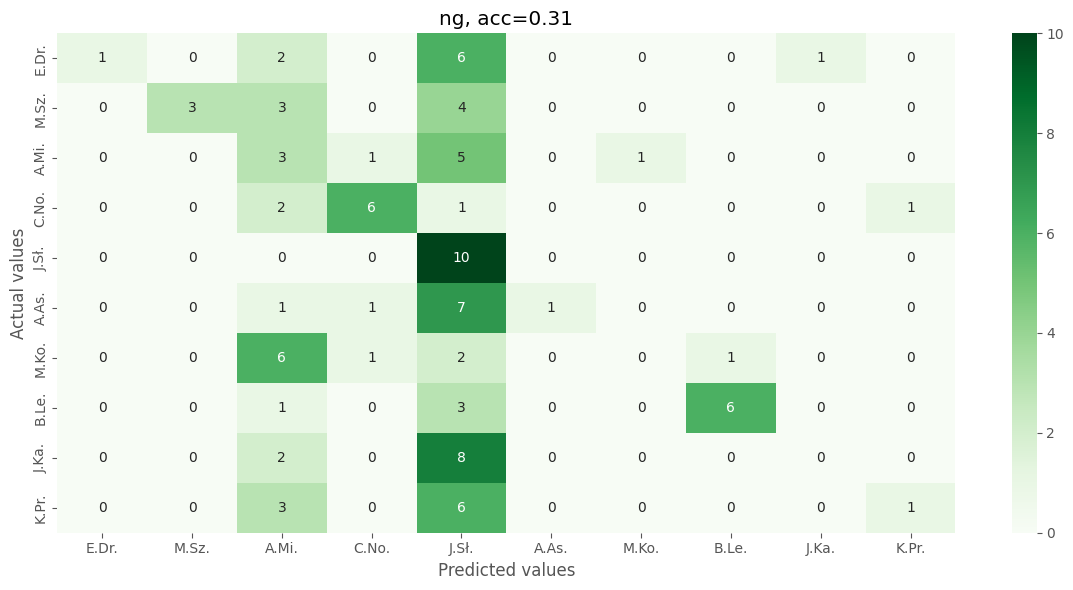

In [ ]:
p.print_confussion_matrix()

### Możliwy rozwój projektu - wyjaśnialność klasyfikatorów opartych o modele n-gramowe

In [ ]:
def lime_path(true_class: str):
  prep_descr = preps_descr[number_of_dataset % 10]
  return f'../figures/explanation/lime/ng_lime_fig{train_size_words}_{test_size}_{words_num_in_par}_{prep_descr}_{kinds_descr}_{true_class}.jpg'


In [ ]:
expl = Explain(p)

In [ ]:
#true_author = 'Henryk Sienkiewicz'
#true_author = 'Adam Mickiewicz'
true_author = 'Juliusz Słowacki'
if true_author == 'Henryk Sienkiewicz':
  lime_text_path = './text_examples/sienkiewicz.txt'
if true_author == 'Adam Mickiewicz':
  lime_text_path = './text_examples/mickiewicz.txt'
if true_author == 'Juliusz Słowacki':
  lime_text_path = './text_examples/slowacki.txt'
with open(lime_text_path) as f:
  text = f.read()
print(len(text.split()))

199


In [ ]:
pos = ['ADJ', 'NOUN', 'VERB']
preprocessing_list = ['anonymize', 'lower_text', 'remove_stop_words']#,'POS_leave_only']#, 'lemmatize_text', 'remove_punctuation']
text = expl.text_preprocessing(text, preprocessing_list, pos)
print(text)
print(len(text.split()))

beniowski (nieznane strofy)

zapłoną skrzące komet miotły 
księżyc krwawo borem zaszczeka, 
niechaj wonie, bluszczem oplotły 
duszy mej rubin, wiatr narzeka - 
uderzą razem, złociste kotły, 
roztęczy melodii rzeka, 
bom cyprys, smętnie kłoni, 
swój obraz patrząc, srebrnej rzucon toni.

gwiazdy wystrzelają żagwie 
niebo płacze straszliwym pożarem, 
chmur klucze, stalowe lagwie 
biegną zatłuc kłębowiskiem szarem 
popiołów mrocznych wstąg czarnych. 
wędrowiec nocą zabłąkany harem, 
oczy dojrzy, płoną szmaragd, 
zatoną faldów katarakt.

czekajcie owe miotliska, 
barw złociste zapachów tany 
nocnych cieni. niechaj kołyska 
purpury pełna, róż przybrana wiany
trumna skrzydeł zabłyska 
białych aniołów, kurhany 
stać , ziół ni kwietnych plastrów, 
placename jaśni alabastrów.

później, kręgach szafiru, opalu, 
smugach dziwnych, gwiazdy niosą, 
ujrzym . sercu koralu 
znamię wyryte, kosą 
krzyżyk wycięty murawie - szalu 
niezapominek pokropionych rosą 
rzucisz niebieskie srebrne naręcze, 
ranę wyg

In [ ]:
#print(expl.classify(text, 0))

In [ ]:
#expl.lime(text, 0, lime_path(true_author), true_author)